# MaskGIT Demo

## Clone Repository

In [1]:
!git clone https://github.com/sunnyanthony/MaskGIT-pytorch.git
%cd MaskGIT-pytorch

%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0 webdataset>=2.0 huggingface_hub

Cloning into 'MaskGIT-pytorch'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 99 (delta 26), reused 78 (delta 11), pack-reused 0
Receiving objects: 100% (99/99), 12.42 MiB | 29.65 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/MaskGIT-pytorch


## Download Pretrained models

In [2]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="llvictorll/Maskgit-pytorch", filename="pretrained_maskgit/VQGAN/last.ckpt", local_dir=".")
hf_hub_download(repo_id="llvictorll/Maskgit-pytorch", filename="pretrained_maskgit/VQGAN/model.yaml", local_dir=".")
hf_hub_download(repo_id="llvictorll/Maskgit-pytorch", filename="pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_256.pth", local_dir=".")
hf_hub_download(repo_id="llvictorll/Maskgit-pytorch", filename="pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_512.pth", local_dir=".")

last.ckpt:   0%|          | 0.00/958M [00:00<?, ?B/s]

pretrained_maskgit/VQGAN/model.yaml:   0%|          | 0.00/645 [00:00<?, ?B/s]

MaskGIT_ImageNet_256.pth:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

MaskGIT_ImageNet_512.pth:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

'./pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_512.pth'

In [3]:
import os
# restrict the memory usage
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:2048'
import random
import math
import seaborn as sns

import numpy as np
import argparse

import torch
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt

from Trainer.vit import MaskGIT

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# MaskGIT initialisation

### Load cifar10 dataset

In [4]:
from torchvision.datasets.cifar import CIFAR10
CIFAR10('./Dataset/CIFAR10/', download=True, train=True)
CIFAR10('./Dataset/CIFAR10/', download=True, train=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 54494835.58it/s]


Extracting ./Dataset/CIFAR10/cifar-10-python.tar.gz to ./Dataset/CIFAR10/
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./Dataset/CIFAR10/
    Split: Test

In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Args(argparse.Namespace):
    data_folder="./Dataset/CIFAR10"
    vit_folder="./pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_512.pth"
    vqgan_folder="./pretrained_maskgit/VQGAN/"
    writer_log=""
    data = "cifar10"
    mask_value = 1024                                                            # Value of the masked token
    img_size = 512                                                               # Size of the image
    path_size = img_size // 16                                                   # Number of vizual token
    seed = 1                                                                     # Seed for reproducibility
    channel = 3                                                                  # Number of input channel
    num_workers = 4                                                              # Number of workers
    iter = 1_500_000                                                             # 750_000 at 256*256 + 750_000 at 512*512
    global_epoch = 380                                                           # 300 epoch w/ bsize 512 + 80 epoch with bsize 128
    lr = 1e-4                                                                    # Learning rate
    drop_label = 0.1                                                             # Drop out label for cfg
    resume = True                                                                # Set to True for loading model
    device = device                                                              # Device
    print(device)
    debug = False                                                                # Load dataloader
    test_only = False                                                            # Dont launch the testing
    is_master = True                                                             # Master machine
    is_multi_gpus = False                                                        # set to False for colab
    grad_cum = 500                                                               # small grad_cum for cifar10
    bsize=2                                                                      # small batch size for training

args=Args()

# Fixe seed
if args.seed > 0:
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)
    torch.backends.cudnn.enable = False
    torch.backends.cudnn.deterministic = True

# Instantiate the MaskGIT
maskgit = MaskGIT(args)

cuda
load ckpt from: ./pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_512.pth
Size of model vit: 176.307M
Size of model autoencoder: 72.142M


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
def viz(x, nrow=10, pad=2, size=(18, 18)):
    """
    Visualize a grid of images.

    Args:
        x (torch.Tensor): Input images to visualize.
        nrow (int): Number of images in each row of the grid.
        pad (int): Padding between the images in the grid.
        size (tuple): Size of the visualization figure.

    """
    nb_img = len(x)
    min_norm = x.min(-1)[0].min(-1)[0].min(-1)[0].view(-1, 1, 1, 1)
    max_norm = x.max(-1)[0].max(-1)[0].max(-1)[0].view(-1, 1, 1, 1)
    x = (x - min_norm) / (max_norm - min_norm)

    x = vutils.make_grid(x.float().cpu(), nrow=nrow, padding=pad, normalize=False)
    plt.figure(figsize = size)
    plt.axis('off')
    plt.imshow(x.permute(1, 2, 0))
    plt.show()

def decoding_viz(gen_code, mask, maskgit):
    """
    Visualize the decoding process of generated images with associated masks.

    Args:
        gen_code (torch.Tensor): Generated code for decoding.
        mask (torch.Tensor): Mask used for decoding.
        maskgit (MaskGIT): MaskGIT instance.
    """
    start = torch.FloatTensor([1, 1, 1]).view(1, 3, 1, 1).expand(1, 3, maskgit.patch_size, maskgit.patch_size) * 0.8
    end = torch.FloatTensor([0.01953125, 0.30078125, 0.08203125]).view(1, 3, 1, 1).expand(1, 3, maskgit.patch_size, maskgit.patch_size) * 1.4
    code = torch.stack((gen_code), dim=0).squeeze()
    mask = torch.stack((mask), dim=0).view(-1, 1, maskgit.patch_size, maskgit.patch_size).cpu()

    with torch.no_grad():
        x = maskgit.ae.decode_code(torch.clamp(code, 0, 1023))

    binary_mask = mask * start + (1 - mask) * end
    binary_mask = vutils.make_grid(binary_mask, nrow=len(gen_code), padding=1, pad_value=0.4, normalize=False)
    binary_mask = binary_mask.permute(1, 2, 0)

    plt.figure(figsize = (18, 2))
    plt.gca().invert_yaxis()
    plt.pcolormesh(binary_mask, edgecolors='w', linewidth=.5)
    plt.axis('off')
    plt.show()

    viz(x, nrow=len(gen_code))

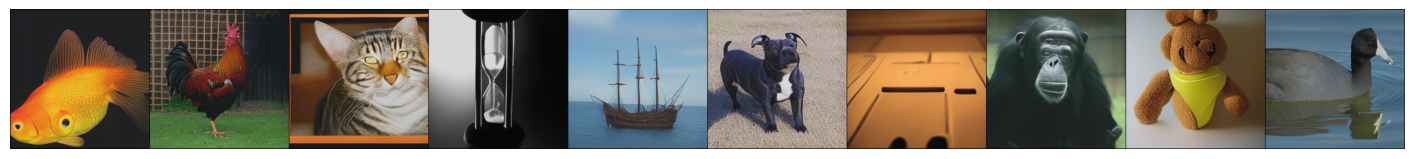

In [7]:
sm_temp = 1.3          # Softmax Temperature
r_temp = 7             # Gumbel Temperature
w = 9                  # Classifier Free Guidance
randomize = "linear"   # Noise scheduler
step = 32              # Number of step
sched_mode = "arccos"  # Mode of the scheduler

labels, name = [1, 7, 282, 604, 724, 179, 681, 367, 850, random.randint(0, 999)] * 1, "r_row"
labels = torch.LongTensor(labels).to(args.device)
# Generate sample
gen_sample, gen_code, l_mask = maskgit.sample(nb_sample=labels.size(0), labels=labels, sm_temp=sm_temp, w=w, randomize=randomize, r_temp=r_temp, sched_mode=sched_mode, step=step)

viz(gen_sample, nrow=10, size=(18, 18))

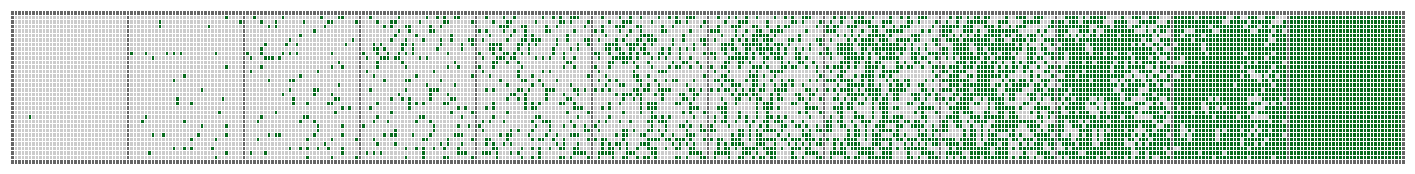

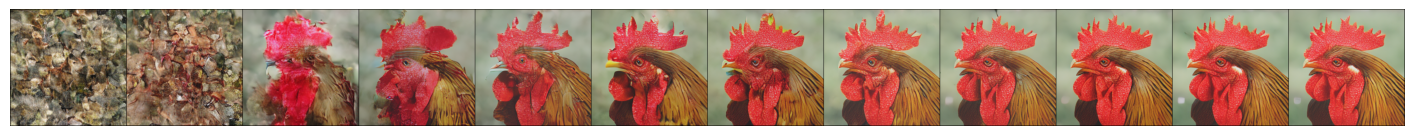

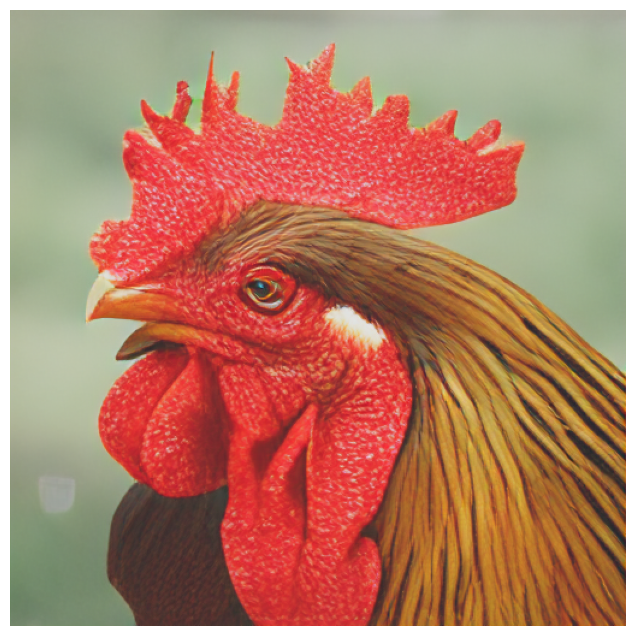

In [8]:
labels, name = 7, "chicken"
sample, code, mask = maskgit.sample(nb_sample=1, labels=torch.LongTensor([labels]).to(args.device), sm_temp=1.3, w=9, randomize="linear", r_temp=4.5, sched_mode="arccos", step=12)
decoding_viz(code, mask, maskgit=maskgit)
viz(sample, size=(8,8))

### Monkey-patching the MaskGiT class

In [7]:
from torch import nn
# Add new label
new_label_num = 1
original_label_dim = 1024+1+1000+1
network_hid_dim = 768
bias_dim = 1025

tok_emb = nn.Embedding(original_label_dim+new_label_num, network_hid_dim).to(device)
tok_emb.weight.data.zero_()
tok_emb.weight.data[:original_label_dim] = maskgit.vit.tok_emb.weight.data
temp = torch.rand(bias_dim, original_label_dim+new_label_num).to(device)
temp[:,:original_label_dim] = maskgit.vit.bias
maskgit.vit.tok_emb = tok_emb
maskgit.vit.bias = nn.Parameter(temp).to(device)

#### Check the new label

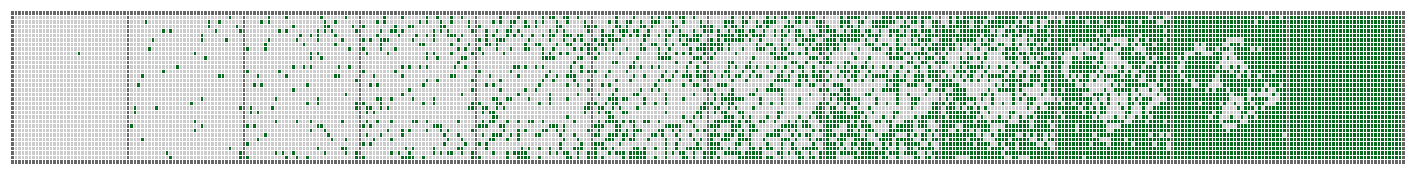

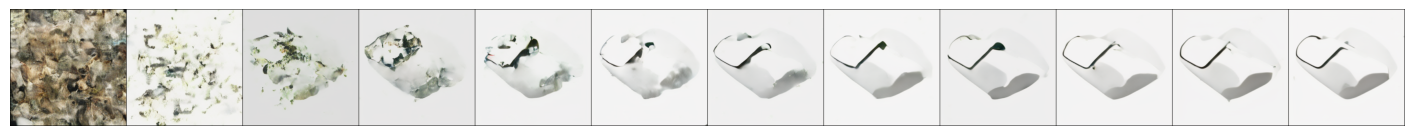

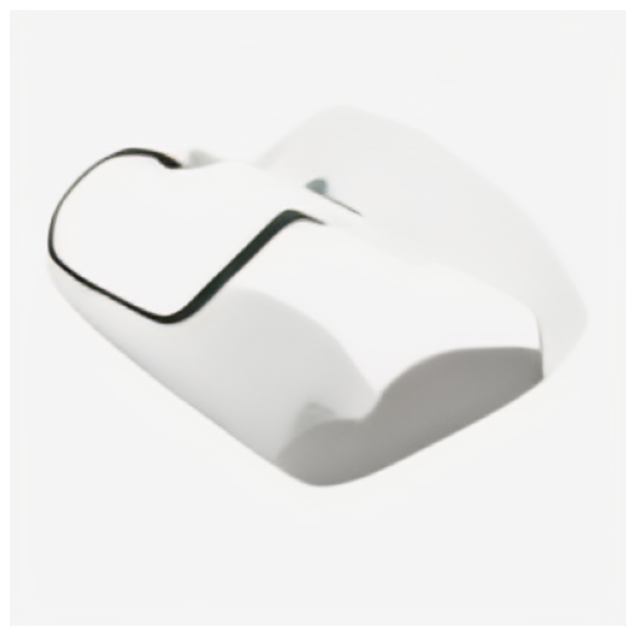

In [10]:
labels, name = 1001, "unknown"
sample, code, mask = maskgit.sample(nb_sample=1, labels=torch.LongTensor([labels]).to(args.device), sm_temp=1.3, w=9, randomize="linear", r_temp=4.5, sched_mode="arccos", step=12)
decoding_viz(code, mask, maskgit=maskgit)
viz(sample, size=(8,8))

### Training... with the modified train_one_epoch
We trained it with only 10,000 iterations and skipped iterations that lacked a target in the label.

In [8]:
# only support batch size 2
import torch
def train_one_epoch(maskgit, targer_label, train_data, stop_iter, new_label=1001):
    """ Train the model for 1 epoch """
    maskgit.vit.train()
    cum_loss = 0.0
    image = None

    for x, y in tqdm(train_data, leave=False):

        if stop_iter == maskgit.args.iter:
            # due to GPU limitation for the free account of colab
            break

        maskgit.args.iter += 1

        # train lable with CIFAR-10 and make it to be 1001 label
        drop_label = 0
        if targer_label in y:
            index = torch.where(y == targer_label)[0][0].item()
            if image is None:
                image = x[index].clone()
        else:
            continue

        y[y == targer_label] = y[y == targer_label] + (new_label - targer_label)
        x = x.to(maskgit.args.device)
        y = y.to(maskgit.args.device)
        x = 2 * x - 1  # normalize from x in [0,1] to [-1,1] for VQGAN

        # VQGAN encoding to img tokens
        with torch.no_grad():
            emb, _, [_, _, code] = maskgit.ae.encode(x)
            code = code.reshape(x.size(0), maskgit.patch_size, maskgit.patch_size)

        # Mask the encoded tokens
        masked_code, mask = maskgit.get_mask_code(code, value=maskgit.args.mask_value)

        with torch.cuda.amp.autocast():                             # half precision
            pred = maskgit.vit(masked_code, y, drop_label=drop_label)  # The unmasked tokens prediction
            # Cross-entropy loss
            loss = maskgit.criterion(pred.reshape(-1, 1024 + 1), code.view(-1)) / maskgit.args.grad_cum

        # update weight if accumulation of gradient is done
        update_grad = maskgit.args.iter % maskgit.args.grad_cum == maskgit.args.grad_cum - 1
        if update_grad:
            maskgit.optim.zero_grad()

        maskgit.scaler.scale(loss).backward()  # rescale to get more precise loss

        if update_grad:
            maskgit.scaler.unscale_(maskgit.optim)                      # rescale loss
            nn.utils.clip_grad_norm_(maskgit.vit.parameters(), 1.0)  # Clip gradient
            maskgit.scaler.step(maskgit.optim)
            maskgit.scaler.update()

    return image #cum_loss / n

maskgit.args.iter = 0
image = train_one_epoch(maskgit, 5, maskgit.train_data, 10000)

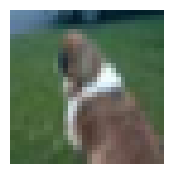

In [19]:
image = F.interpolate(image.unsqueeze(0), size=32, mode='bilinear', align_corners=False)
image = image[0] * 0.5 + 0.5
image = image.clamp(0, 1)
plt.figure(figsize = (2,2))
plt.axis('off')
plt.imshow(image.numpy().transpose(1, 2, 0))
plt.show()

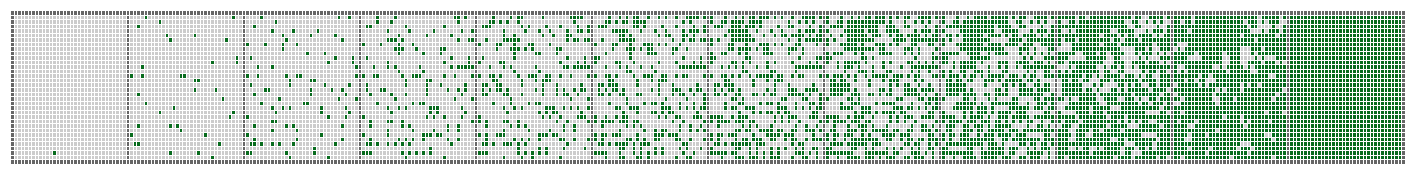

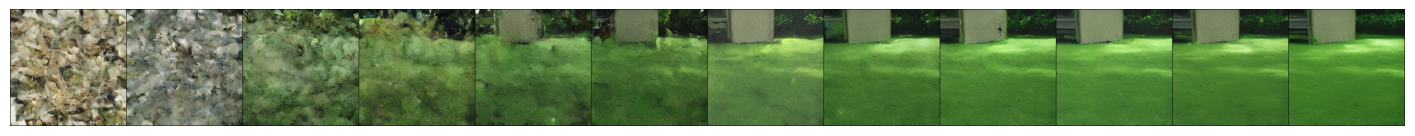

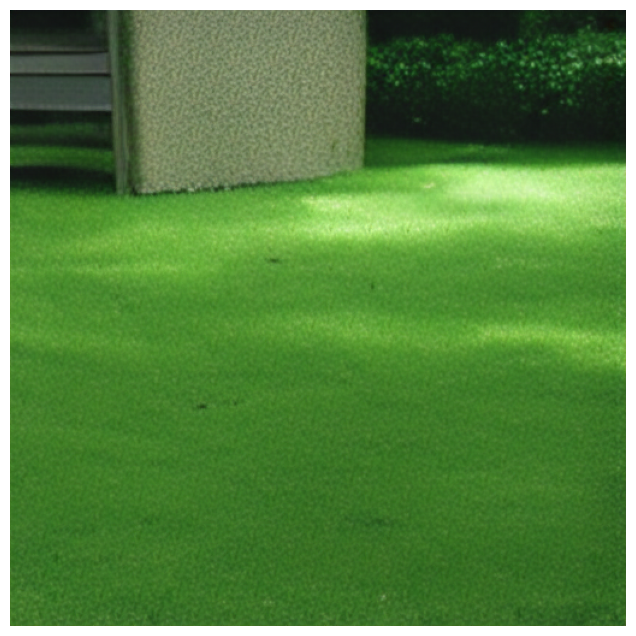

In [13]:
labels, name = 1001, "dogs"
sample, code, mask = maskgit.sample(nb_sample=1, labels=torch.LongTensor([labels]).to(args.device), sm_temp=1.3, w=9, randomize="linear", r_temp=4.5, sched_mode="arccos", step=12)
decoding_viz(code, mask, maskgit=maskgit)
viz(sample, size=(8,8))

### It will not affect the original label

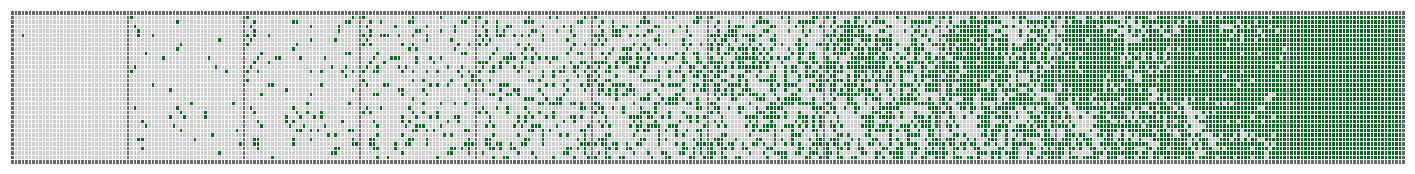

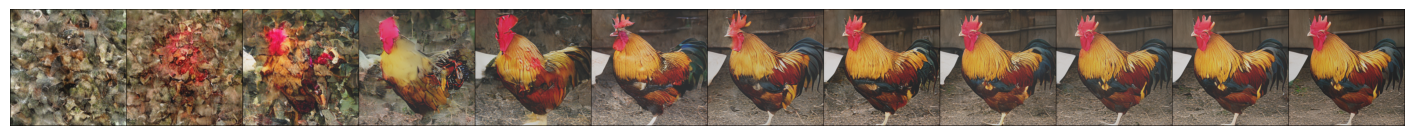

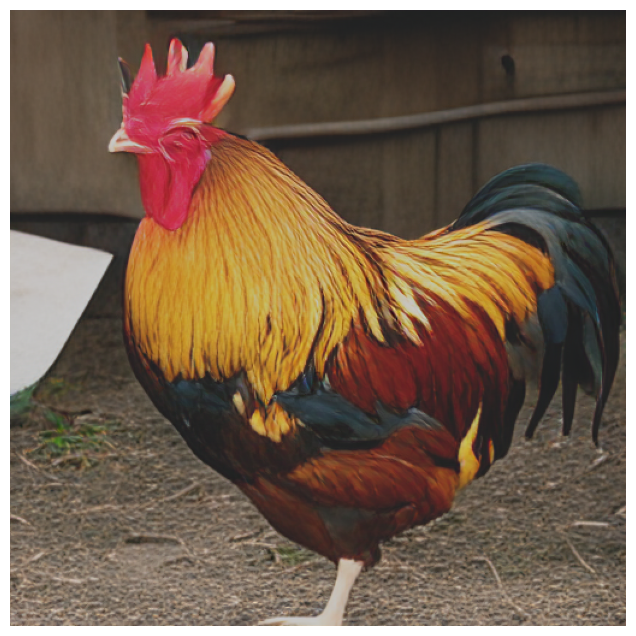

In [23]:
labels, name = 7, "chicken"
sample, code, mask = maskgit.sample(nb_sample=1, labels=torch.LongTensor([labels]).to(args.device), sm_temp=1.3, w=9, randomize="linear", r_temp=4.5, sched_mode="arccos", step=12)
decoding_viz(code, mask, maskgit=maskgit)
viz(sample, size=(8,8))